# langGraph人在回路
LangGraph 框架如何支持 **“人在回路”（Human-in-the-Loop）** 的工作流设计，核心是通过其 **持久化层（Persistence Layer）** 和 **中断机制（Interrupt）** 实现人工干预。

---

### **核心概念解析**
1. **问题背景**  
   - **Agent 的不可靠性**：AI Agent 执行复杂任务时可能出错或无法独立完成（如缺乏关键信息、执行敏感操作）。
   - **人工干预需求**：某些高风险操作（如支付、数据删除）需人类审核批准后才能执行，确保安全可控。

2. **LangGraph 的解决方案**  
   - **持久化层（Persistence Layer）**：  
     - 自动保存工作流执行状态（如节点数据、变量值）。
     - 允许工作流 **暂停后恢复**，无需从头开始。
   - **中断函数（`interrupt`）**：  
     - 在节点代码中调用 `interrupt()` 会 **主动暂停工作流**。
     - 类似 Python 的 `input()` 函数，但专为分布式系统设计（支持异步等待外部输入）。

3. **工作流程**  
   ```mermaid
   graph LR
   A[Agent执行任务] --> B{需人工干预？}
   B -- 是 --> C[调用interrupt暂停]
   C --> D[等待人工输入]
   D -- 用户提交指令Command --> E[注入新输入]
   E --> F[恢复工作流]
   B -- 否 --> G[继续执行]
   ```

4. **关键接口**  
   - **暂停**：在节点中调用 `interrupt()` → 工作流状态持久化存储，进入等待状态。
   - **恢复**：用户通过 **命令（Command）** 提交决策（如批准/拒绝）→ 携带新输入重启工作流。

5. **与 Python `input()` 的异同**  
   | **特性**         | **Python `input()`**       | **LangGraph `interrupt()`**       |
   |------------------|----------------------------|-----------------------------------|
   | **运行环境**     | 本地命令行阻塞             | 分布式系统异步暂停                |
   | **状态管理**     | 无自动持久化               | 自动保存完整状态（节点、变量等）  |
   | **恢复方式**     | 直接输入回车继续           | 需通过API注入`Command`重启        |
   | **适用场景**     | 单机脚本                   | 生产级AI Agent系统                |

6. **注意事项（Caveats）**  
   - **超时处理**：需设置等待超时机制，避免无限期阻塞。
   - **输入验证**：人工输入的 `Command` 需做安全校验（如防止注入攻击）。
   - **状态隔离**：多并发场景下需保证各工作流状态独立存储。

---

### **典型应用场景**
1. **金融审核**  
   - Agent 检测到转账金额超过阈值 → `interrupt()` 暂停 → 等待风控人员审批 → 审批通过后继续执行支付。

2. **敏感操作确认**  
   - 删除数据库前调用 `interrupt()` → 向管理员发送确认请求 → 管理员回复 `CONFIRM_DELETE` 命令 → 执行删除。

3. **动态补充信息**  
   - Agent 发现缺失用户地址 → 暂停流程 → 人工补充地址信息 → 恢复物流派送任务。

---

### **总结**
LangGraph 通过 `interrupt()` 机制将 **人工决策** 无缝嵌入自动化工作流：  
1. **可控性**：高风险操作必经人工审批，避免AI盲目执行。  
2. **灵活性**：持久化层保证中断后可恢复，支持复杂长周期任务。  
3. **工程化**：提供类 `input()` 的简洁接口，降低开发成本（但需注意分布式场景下的特殊性）。  

> **开发者建议**：在涉及资金、数据变更或法律合规的节点中主动调用 `interrupt()`，并将人工输入通过严格的 `Command` 枚举类型传递（如 `APPROVE/REJECT`），确保系统安全可靠。

In [ ]:
import os
from langchain.chat_models import init_chat_model

# 设置自定义API配置
os.environ["QWEN_API_KEY"] = "You API Key"
os.environ["QWEN_API_BASE"] = "https://dashscope.aliyuncs.com/compatible-mode/v1"

# 使用自定义配置
llm = init_chat_model(
    model="qwen-plus-latest",
    model_provider="openai",
    api_key=os.environ["QWEN_API_KEY"],
    base_url=os.environ["QWEN_API_BASE"]
)

In [2]:
import os
import getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


这段代码使用 LangGraph 构建了一个支持人工干预的智能代理工作流，结合了工具调用和人工中断功能。以下是详细解释：

### 1. **核心组件定义**
```python
# 状态定义：包含消息列表
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 自动合并消息的特殊注解

# 图构建器
graph_builder = StateGraph(State)
```
- **`State`**：工作流状态对象，核心是 `messages` 列表
- **`add_messages`**：自动合并新旧消息的处理器（避免手动拼接）
- **`StateGraph`**：基于状态的工作流构建器

---

### 2. **工具定义**
```python
@tool
def human_assistance(query: str) -> str:
    """人工协助工具"""
    human_response = interrupt({"query": query})  # 关键中断点
    return human_response["data"]  # 返回人工输入

# 搜索工具
tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]  # 工具组合

# 绑定工具到LLM
llm_with_tools = llm.bind_tools(tools)
```
- **`human_assistance`** 工具：
  - 调用 `interrupt()` 暂停工作流
  - 等待人工输入（通过 `Command` 恢复）
  - 返回格式：`{"data": "人工输入内容"}`
- **`TavilySearch`**：网络搜索工具（限制2个结果）
- **`bind_tools`**：让LLM能识别并调用这些工具

---

### 3. **节点定义**
```python
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1  # 禁用并行调用
    return {"messages": [message]}

tool_node = ToolNode(tools=tools)  # 预构建工具节点
```
- **`chatbot` 节点**：
  - 调用LLM处理当前消息
  - `assert` 确保每次最多调用1个工具（避免中断恢复时的冲突）
  - 返回LLM生成的消息
- **`ToolNode`**：
  - 预构建的通用工具执行节点
  - 自动处理 `tool_calls` 并返回结果

---

### 4. **工作流构建**
```python
# 添加节点
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# 条件路由
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,  # 预定义判断：有工具调用→tools节点，无→END
)

# 节点连接
graph_builder.add_edge("tools", "chatbot")  # 工具执行后返回chatbot
graph_builder.add_edge(START, "chatbot")    # 入口指向chatbot
```
- **节点关系**：
  ```mermaid
  graph LR
    START --> chatbot
    chatbot -- 有工具调用 --> tools
    tools --> chatbot
    chatbot -- 无工具调用 --> END
  ```
- **`tools_condition`** 逻辑：
  ```python
  def tools_condition(state: State):
      last_msg = state["messages"][-1]
      if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
          return "tools"  # 转工具节点
      return END         # 结束
  ```

---

### 5. **中断机制详解**
当执行到 `human_assistance` 工具时：
1. **触发中断**：
   ```python
   interrupt({"query": "需要人工确认的问题"})
   ```
2. **工作流暂停**：
   - 当前状态自动保存到持久层
   - 返回HTTP 202状态码（Accepted）
3. **人工干预**：
   - 系统展示问题给用户
   - 用户通过API提交 `Command`：
     ```json
     {
       "command": "resume",
       "input": {"data": "人工回复内容"}
     }
     ```
4. **恢复执行**：
   - `human_assistance` 返回用户输入
   - 工作流从断点继续

---

### 6. **完整工作流示例**
假设用户提问："纽约的GDP是多少？"
1. `START → chatbot`：LLM决定调用搜索工具
2. `chatbot → tools`：执行TavilySearch，返回GDP数据
3. `tools → chatbot`：LLM发现数据不完整，调用人工工具：
   ```python
   human_assistance("GDP数据有冲突，请确认使用2023还是2024年数据？")
   ```
4. **中断**：等待人工输入
5. **恢复**（人工输入"2024"）：
   - 人工输入注入消息流
   - LLM整合数据生成最终回复
6. 无工具调用 → 结束

---

### 关键设计特点
1. **人工介入点**：
   - 通过 `interrupt()` 在任意工具中暂停
   - 无需修改核心工作流逻辑
2. **状态安全**：
   - 中断时自动保存完整状态（含消息历史）
   - 恢复时精确回到中断点
3. **工具约束**：
   - 禁用并行工具调用 (`assert`)
   - 避免中断恢复时的状态冲突
4. **标准化接口**：
   - 人工输入统一通过 `{"data": ...}` 格式返回
   - 与普通工具返回格式兼容

> **典型应用场景**：金融审核、医疗决策、法律咨询等需要人工确认的高风险领域

In [3]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

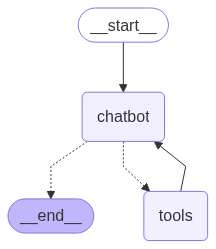

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
user_input = "我想构建一家无人机，你可以给我推荐些专家吗？"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

我想构建一家无人机，你可以给我推荐些专家吗？
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_42b58a2261284340bb7e85)
 Call ID: call_42b58a2261284340bb7e85
  Args:
    query: 我想构建一家无人机，你可以给我推荐些专家吗？


In [6]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [7]:
human_response = (
    "我们专家在此为您提供帮助！我们推荐您使用大疆来构建您的智能代理无人机。"
    " 相比简单的自主代理无人机，它更加可靠且具有更好的可扩展性。"
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_42b58a2261284340bb7e85)
 Call ID: call_42b58a2261284340bb7e85
  Args:
    query: 我想构建一家无人机，你可以给我推荐些专家吗？
================================= Tool Message =================================
Name: human_assistance

我们专家在此为您提供帮助！我们推荐您使用大疆来构建您的智能代理无人机。 相比简单的自主代理无人机，它更加可靠且具有更好的可扩展性。
================================== Ai Message ==================================

我们建议您考虑使用大疆（DJI）的产品来构建您的智能代理无人机。相比简单的自主代理无人机，大疆的解决方案更加可靠，并且具备更好的可扩展性，能够为您的项目提供强有力的支持！如果您有更具体的需求或问题，欢迎随时提问。


In [16]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [17]:
def interactive_test():
    """交互式测试"""
    config = {"configurable": {"thread_id": "interactive"}}
    
    print("🤖 带人工协助的聊天机器人已启动！")
    print("💡 提示: 询问需要人工协助的问题（如预订、联系等）会触发中断")
    
    while True:
        user_input = input("\n你: ")
        if user_input.lower() in ['quit', 'exit', '退出']:
            print("👋 再见！")
            break
            
        try:
            result = graph.invoke(
                {"messages": [("user", user_input)]}, 
                config
            )
            print(f"🤖: {result['messages'][-1].content}")
            
        except Exception as e:
            if "interrupt" in str(e).lower():
                print("🔔 需要人工协助...")
                human_response = input("👤 请提供协助: ")
                
                # 继续执行
                result = graph.invoke(
                    None,
                    config, 
                    input={"data": human_response}
                )
                print(f"🤖: {result['messages'][-1].content}")
            else:
                print(f"❌ 错误: {e}")

# 运行交互式测试
interactive_test()

🤖 带人工协助的聊天机器人已启动！
💡 提示: 询问需要人工协助的问题（如预订、联系等）会触发中断



你:  最新的科技新闻


🤖: 以下是最近的科技新闻摘要：

1. **TeamGroup 发布自毁 SSD**  
   TeamGroup 展示了一款带有红色按钮的自毁 SSD，可实现即时数据销毁。这项技术对于需要高安全性的用户来说是一个重要进展。

2. **ASUS 推出价值 50 万美元的 RTX 5090 ROG Astral (Real) Gold Edition**  
   华硕展示了其高端显卡 RTX 5090 ROG Astral 的黄金版，售价高达 50 万美元，吸引了广泛关注。

3. **NVIDIA 再推 Cyberpunk 2077 显卡**  
   NVIDIA 推出了新的 RTX 5090 显卡，并计划将其作为赠品送给部分用户，与《Cyberpunk 2077》游戏结合推广。

4. **AYANEO Flip 1S DS 游戏掌机发布**  
   AYANEO 推出了搭载 Ryzen AI 9 HX 370 处理器的双屏游戏掌机 Flip 1S DS，售价 1,299 美元。

5. **Silicon Motion 推出 PCIe Gen6 SSD 控制器**  
   Silicon Motion 发布了支持最高 28 GB/s 速度的 PCIe Gen6 SSD 控制器，为存储性能带来了显著提升。

6. **AMD Radeon RX 9070 GRE 显卡评测**  
   AMD 的 Radeon RX 9070 GRE 显卡在媒体评测中表现出色，但受限于 12GB VRAM 容量，未能完全发挥潜力。

如需了解详细信息，可以访问相关链接查看完整报道。



你:  帮我预订明天的机票


🤖: 



你:  6


❌ 错误: Error code: 400 - {'error': {'code': 'invalid_parameter_error', 'param': None, 'message': '<400> InternalError.Algo.InvalidParameter: An assistant message with "tool_calls" must be followed by tool messages responding to each "tool_call_id". The following tool_call_ids did not have response messages: message[6].role', 'type': 'invalid_request_error'}, 'id': 'chatcmpl-566a8056-ffac-9d1d-8825-6f44be962e17', 'request_id': '566a8056-ffac-9d1d-8825-6f44be962e17'}



你:  quit


👋 再见！


In [18]:
# 运行交互式测试
interactive_test()

🤖 带人工协助的聊天机器人已启动！
💡 提示: 询问需要人工协助的问题（如预订、联系等）会触发中断



你:  帮我预订明天的机票


❌ 错误: Error code: 400 - {'error': {'code': 'invalid_parameter_error', 'param': None, 'message': '<400> InternalError.Algo.InvalidParameter: An assistant message with "tool_calls" must be followed by tool messages responding to each "tool_call_id". The following tool_call_ids did not have response messages: message[6].role', 'type': 'invalid_request_error'}, 'id': 'chatcmpl-3a663e82-feeb-95ad-a7a7-c2d1d84085e4', 'request_id': '3a663e82-feeb-95ad-a7a7-c2d1d84085e4'}



你:  quit


👋 再见！
